In [1]:
import pandas as pd
import re
import networkx as nx

>* We are going back to week 5 when we analyzed social media data to build edges between users. We will use the data from week 3, which is collected from Politician's Twitter and Facebook accounts. We will use the data to build a social network graph and analyze the network.

In [2]:
data=pd.read_csv('../week3/Political-media-DFE.csv', encoding='latin1')

In [3]:
data.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'audience', 'audience:confidence', 'bias',
       'bias:confidence', 'message', 'message:confidence', 'orig__golden',
       'audience_gold', 'bias_gold', 'bioid', 'embed', 'id', 'label',
       'message_gold', 'source', 'text'],
      dtype='object')

>* Let's subset the DataFrame to have `label`, `source`, and `text` columns

In [4]:
df=data[['label', 'source', 'text']]

>* With this DataFrame, we want to extract the name of the user from the `label` column and create a new column called `username` in the DataFrame.

In [5]:
pattern=re.compile(r'(.+?)\s*\(')
df['username']=df['label'].str.replace('From: ', '').str.findall(pattern).str[0]

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1629/1246208881.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['username']=df['label'].str.replace('From: ', '').str.findall(pattern).str[0]


>* Let's lowercase the `username` column

In [6]:
df['username']=df['username'].str.lower()

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1629/3231511176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['username']=df['username'].str.lower()


> * Let's extract the mentions from the `text` column and create a new column `mention` with the mentions.

In [7]:
pattern = re.compile(r'@[a-zA-Z0-9]+')
df['mention']=df['text'].apply(lambda x: pattern.findall(x))
df['mention']=df['mention'].apply(lambda x: [y.lower() for y in x])

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1629/704253825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mention']=df['text'].apply(lambda x: pattern.findall(x))
/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1629/704253825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mention']=df['mention'].apply(lambda x: [y.lower() for y in x])


>* We also don't want to forget to convert the text into lowercase.

In [8]:
df['text']=df['text'].str.lower()

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1629/473300915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text']=df['text'].str.lower()


In [9]:
df.head(5)

,label,source,text,username,mention
0,From: Trey Radel (Representative from Florida),twitter,rt @nowthisnews: rep. trey radel (r- #fl) slam...,trey radel,[@nowthisnews]
1,From: Mitch McConnell (Senator from Kentucky),twitter,video - #obamacare: full of higher costs and ...,mitch mcconnell,[]
2,From: Kurt Schrader (Representative from Oregon),twitter,please join me today in remembering our fallen...,kurt schrader,[]
3,From: Michael Crapo (Senator from Idaho),twitter,rt @senatorleahy: 1st step toward senate debat...,michael crapo,[@senatorleahy]
4,From: Mark Udall (Senator from Colorado),twitter,.@amazon delivery #drones show need to update ...,mark udall,[@amazon]


> * Let's build edges between the users who have mentioned.
> * To do so, we will use the `mention` column and iterate over the rows to create edges between the users in the `mention` column.

>* There is an information about whether the political leader is a Representative or a Senator.
>* Let's use RegEx to extract that and create a dictionary called `title`.

In [10]:
pattern=re.compile(r'\([A-Za-z]*')
df['title']=df['label'].str.findall(pattern).str[0].str.strip('(')

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1629/738137026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title']=df['label'].str.findall(pattern).str[0].str.strip('(')


In [11]:
title={}
for idx, row in df.iterrows():
    title[row['username']]=row['title']

In [12]:
title_shape = {key: 'o' if value == 'Representative' else 'x' for key, value in title.items()}

>* There is another information about which State the political leader is from.
>* Let's use RegEx to extract that and create a dictionary called `state`.
>* We are changing the value of Representative and Senator to 'o' and 'x' to use it as a node shape.

In [13]:
pattern=re.compile(r'from\s.*')
df['state']=df['label'].str.findall(pattern).str[0].str.replace('from','').str.replace(')', '').str.strip()

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1629/1849310204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state']=df['label'].str.findall(pattern).str[0].str.replace('from','').str.replace(')', '').str.strip()


In [14]:
state={}
for idx, row in df.iterrows():
    state[row['username']]=row['state']

In [15]:
import random
import seaborn as sns
# Get the unique values from the state dictionary
unique_states = list(set(state.values()))

# Generate a color palette using seaborn
color_palette = sns.color_palette("hls", len(unique_states))

# Create a dictionary to map each unique state to a color
state_colors_dict = {key: color_palette[i] for i, key in enumerate(unique_states)}

In [16]:
df[df['username']=='trey radel']

,label,source,text,username,mention,title,state
0,From: Trey Radel (Representative from Florida),twitter,rt @nowthisnews: rep. trey radel (r- #fl) slam...,trey radel,[@nowthisnews],Representative,Florida
625,From: Trey Radel (Representative from Florida),twitter,ûï@markdotdo: @treyradel dig the new tumblr t...,trey radel,"[@markdotdo, @treyradel]",Representative,Florida
707,From: Trey Radel (Representative from Florida),twitter,@morrow_brett ha! ur the man! u text one night...,trey radel,[@morrow],Representative,Florida
959,From: Trey Radel (Representative from Florida),twitter,why does keeping troops out of #syria matter? ...,trey radel,[],Representative,Florida
1768,From: Trey Radel (Representative from Florida),twitter,#obamacareinthreewords - protected privacy? lol,trey radel,[],Representative,Florida
1885,From: Trey Radel (Representative from Florida),twitter,now following @redmillennial hoping to involve...,trey radel,[@redmillennial],Representative,Florida
2422,From: Trey Radel (Representative from Florida),twitter,transportation sec. announced faa can transfer...,trey radel,[],Representative,Florida


In [17]:
from collections import defaultdict
default_dict=defaultdict(lambda: None, state)
for key, value in state.items():
    if value in state_colors_dict.keys():
        default_dict[key]=state_colors_dict.get(value)
color_mapped=dict(default_dict)

In [18]:
color_palette

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.43237647058823525, 0.33999999999999997),
 (0.86, 0.4935529411764705, 0.33999999999999997),
 (0.86, 0.5547294117647059, 0.33999999999999997),
 (0.86, 0.6159058823529411, 0.33999999999999997),
 (0.86, 0.6770823529411765, 0.33999999999999997),
 (0.86, 0.7382588235294117, 0.33999999999999997),
 (0.86, 0.7994352941176471, 0.33999999999999997),
 (0.8593882352941175, 0.86, 0.33999999999999997),
 (0.7982117647058823, 0.86, 0.33999999999999997),
 (0.7370352941176468, 0.86, 0.33999999999999997),
 (0.6758588235294114, 0.86, 0.33999999999999997),
 (0.6146823529411763, 0.86, 0.33999999999999997),
 (0.5535058823529413, 0.86, 0.33999999999999997),
 (0.4923294117647055, 0.86, 0.33999999999999997),
 (0.4311529411764704, 0.86, 0.33999999999999997),
 (0.36997647058823535, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.86, 0.43237647058823525),
 (0.33999999999999997, 0.86, 0.49355294117647064),
 (0.33999999999999997, 0.86, 0.5547294117647059),
 (0.33999999999999997, 0.86, 0.6159058823529412),
 (0.33999999999999997, 0.86, 0.6770823529411767),
 (0.33999999999999997, 0.86, 0.7382588235294119),
 (0.33999999999999997, 0.86, 0.7994352941176471),
 (0.33999999999999997, 0.8593882352941177, 0.86),
 (0.33999999999999997, 0.7982117647058823, 0.86),
 (0.33999999999999997, 0.7370352941176468, 0.86),
 (0.33999999999999997, 0.6758588235294114, 0.86),
 (0.33999999999999997, 0.6146823529411763, 0.86),
 (0.33999999999999997, 0.553505882352941, 0.86),
 (0.33999999999999997, 0.49232941176470585, 0.86),
 (0.33999999999999997, 0.4311529411764704, 0.86),
 (0.33999999999999997, 0.369976470588235, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.4323764705882351, 0.33999999999999997, 0.86),
 (0.49355294117647014, 0.33999999999999997, 0.86),
 (0.5547294117647059, 0.33999999999999997, 0.86),
 (0.6159058823529411, 0.33999999999999997, 0.86),
 (0.677082352941176, 0.33999999999999997, 0.86),
 (0.7382588235294119, 0.33999999999999997, 0.86),
 (0.799435294117647, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.8593882352941175),
 (0.86, 0.33999999999999997, 0.7982117647058823),
 (0.86, 0.33999999999999997, 0.7370352941176466),
 (0.86, 0.33999999999999997, 0.6758588235294114),
 (0.86, 0.33999999999999997, 0.6146823529411763),
 (0.86, 0.33999999999999997, 0.5535058823529413),
 (0.86, 0.33999999999999997, 0.4923294117647055),
 (0.86, 0.33999999999999997, 0.4311529411764704),
 (0.86, 0.33999999999999997, 0.36997647058823535)]

In [19]:
color_mapped['trey radel']

(0.33999999999999997, 0.4311529411764704, 0.86)

In [20]:
#first we need to iterate through the mention column and then we need to iterate through usernames column
#and we need to create a tuple of the username and the mention

edges=[]
for idx, val in df.iterrows():
    if len(val['mention']) == 0: #when there are no mentions, we skip the iteration
        continue
    elif len(val['mention']) > 0: #when there are mentions, we iterate through the mentions
        for mention in val['mention']: 
            edges.append((val['username'].lower(), mention.strip('@').lower())) 
            #we append the tuple of the username and the mention to the edges list
            #lower() is used to convert the username to lowercase
            #strip() is used to remove the @ from the mention

In [21]:
edges[:10]

[('trey radel', 'nowthisnews'),
 ('michael crapo', 'senatorleahy'),
 ('mark udall', 'amazon'),
 ('heidi heitkamp', 'usdotfra'),
 ('frederica wilson', 'bbcworld'),
 ('gregg harper', 'mha'),
 ('gregg harper', 'genevrapittman'),
 ('gregg harper', 'medcitynews'),
 ('john dingell', 'skitchp'),
 ('kirsten gillibrand', 'corybooker')]

In [22]:
len(edges)

1843

>* We will generate an empty graph object `G` and populate the graph with the edges.

In [23]:
G = nx.Graph()

In [24]:
G.add_edges_from(edges)

>* When you add edges, the graph object will add the nodes automatically.

In [25]:
len(list(G.nodes))

1804

>* Let's add node attributes.
>* We will add the `title` attributes to the node.

In [26]:
df['username']

0            trey radel
1       mitch mcconnell
2         kurt schrader
3         michael crapo
4            mark udall
             ...       
4995           ted yoho
4996           ted yoho
4997           ted yoho
4998           ted yoho
4999           ted yoho
Name: username, Length: 5000, dtype: object

In [27]:
df['title']

0       Representative
1              Senator
2       Representative
3              Senator
4              Senator
             ...      
4995    Representative
4996    Representative
4997    Representative
4998    Representative
4999    Representative
Name: title, Length: 5000, dtype: object

>* We want to try iterating over the `G` object to assign the title as the value of the key `title`.
>* But this will return you an error with the message: `index 0 is out of bounds for axis 0 with size 0`
>* Let's think why this is happening
>* Q. Why is this happening?

In [28]:
#You will get an error from this code.
#Can you think why this error is happening?
for node in G.nodes():
    G.nodes[node]['title']=df[df['username']==node]['title'].unique()[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

>* It is becuase nodes in the graph contains the nodes that are not in the `df['username']`
>* As nodes include the nodes that have been mentioned but not in the `df['username']`, we need to proceess the nodes that are not in `df['username']`.

In [29]:
for node in G.nodes():
    if node in df['username'].values: #check if the node is in the username column
        G.nodes[node]['title']=df[df['username']==node]['title'].unique()[0]
    else: #if the node is not in the username column, we assign the title attribute as Unknown
        G.nodes[node]['title']='Unknown'

In [30]:
G.nodes['nowthisnews']

{'title': 'Unknown'}

>* We will add the `state` attributes to the node.
>* Similarly, we will add `Unknown` to the nodes that are not in the `df['username']`.

In [31]:
for node in G.nodes():
    if node in df['username'].values:
        G.nodes[node]['state']=df[df['username']==node]['state'].unique()[0]
    else:
        G.nodes[node]['state']='Unknown'

In [32]:
G.nodes['nowthisnews']

{'title': 'Unknown', 'state': 'Unknown'}

In [33]:
G.nodes['trey radel']

{'title': 'Representative', 'state': 'Florida'}

>* Now that we have a dictionary, `color_mapped` that as usernames as keys and the value for RGB as values, we can use this dictionary to add the color to the nodes.

In [34]:
color_mapped['trey radel']

(0.33999999999999997, 0.4311529411764704, 0.86)

In [35]:
for node in G.nodes():
    if node in df['username'].values:
        G.nodes[node]['color']=color_mapped[node]
    else:
        G.nodes[node]['color']=(0,0,0)

>* Thus far, we calculated the degree of the nodes by hardcoding the values. But we can use the built-in function of networkx to calculate various centrality measures.

>* Degree centrality: The number of edges that are connected to the node.
>* Betweenness centrality: The number of times the node acts as a bridge along the shortest path between two other nodes.
>* Closeness centrality: The average length of the shortest path between the node and all other nodes.

>* Degree centrality: Node connectivity, local influence
>* Betweenness centrality: Bridging roles, broker
>* Closeness centrality: Proximity to other nodes, efficient communication

In [36]:
nx.degree_centrality(G)['trey radel'] #degree centrality

0.0027731558513588465

In [37]:
nx.betweenness_centrality(G)['trey radel'] #betweenness centrality
#e-06 means 10^-6 or 0.000001

6.155728859842057e-06

In [38]:
nx.closeness_centrality(G)['trey radel'] #closeness centrality

0.0027731558513588465

>* Q. Who are the top 5 usernames who have the highest degree centrality?

In [39]:
sorted(nx.degree_centrality(G).items(), key=lambda x:x[1], reverse=True)[:5]

[('ileana ros-lehtinen', 0.052135330005546314),
 ('cory booker', 0.028840820854132004),
 ('dana rohrabacher', 0.022185246810870772),
 ('john boehner', 0.011092623405435386),
 ('josì© serrano', 0.011092623405435386)]

>* Let's put the degree centrality score as a node attribute called `degree`.
>* To do so, we use the `nx.set_node_attributes` method.

In [40]:
nx.set_node_attributes(G, nx.degree_centrality(G), 'degree')

>* Q. Who are the top 5 usernames who have the highest betweenness centrality?

In [41]:
sorted(nx.betweenness_centrality(G).items(), key=lambda x:x[1], reverse=True)[:5]

[('ileana ros-lehtinen', 0.13645400605026725),
 ('washingtonpost', 0.13067008590507037),
 ('speakerboehner', 0.12029136367414547),
 ('whitehouse', 0.0801739244506154),
 ('john boehner', 0.06366273423531267)]

>* Let's put the betweenness centrality score as a node attribute called `betweenness`.
>* To do so, we use the `nx.set_node_attributes` method.

In [42]:
nx.set_node_attributes(G, nx.betweenness_centrality(G), 'betweenness')

>* Q. Who are the top 5 usernames who have the highest closeness centrality?

In [43]:
sorted(nx.closeness_centrality(G).items(), key=lambda x:x[1], reverse=True)[:5]

[('washingtonpost', 0.147355811037766),
 ('whitehouse', 0.14372348581133293),
 ('ileana ros-lehtinen', 0.14220878481663352),
 ('speakerboehner', 0.14208043753791816),
 ('bill huizenga', 0.13768961352071135)]

>* Let's put the closeness centrality score as a node attribute called `closeness`.
>* To do so, we use the `nx.set_node_attributes` method.

In [44]:
nx.set_node_attributes(G, nx.closeness_centrality(G), 'closeness')

In [45]:
G.nodes['trey radel']

{'title': 'Representative',
 'state': 'Florida',
 'color': (0.33999999999999997, 0.4311529411764704, 0.86),
 'degree': 0.0027731558513588465,
 'betweenness': 6.155728859842057e-06,
 'closeness': 0.0027731558513588465}

>* Homophily is the tendency of individuals to associate and bond with similar others.
>* We can measure homophily by comparing the number of edges between nodes of the same type to the number of edges between nodes of different types.
>* One of popular ways to measure the node-level homophily is to calculate the E-I index proposed by Krackhardt and Stern (1988).
>* https://doi.org/10.2307/2786835

<img src="../week8/ei-index.png" width=500px height=500px />

>* Unfortunately, networkx does not have a built-in function to calculate the E-I index.
>* We will make a function to calculate the E-I index.

>* Let's create `G_eiindex` for the E-I index calculation.

In [46]:
G_eiindex=nx.Graph()
ei_edges=[('mishra', 'park'), ('singh', 'xiao'), ('xiao', 'mishra'), \
        ('xiao', 'park'), ('simon', 'park'), ('simon', 'xiao'), \
        ('simon', 'mishra'), ('simon', 'singh')]
G_eiindex.add_edges_from(ei_edges)

In [47]:
G_eiindex.nodes['mishra']['title']='Representative'
G_eiindex.nodes['singh']['title']='Representative'
G_eiindex.nodes['xiao']['title']='Representative'
G_eiindex.nodes['park']['title']='Sentor'
G_eiindex.nodes['simon']['title']='Sentor'
G_eiindex.nodes['mishra']['color']='blue'
G_eiindex.nodes['singh']['color']='blue'
G_eiindex.nodes['xiao']['color']='blue'
G_eiindex.nodes['park']['color']='red'
G_eiindex.nodes['simon']['color']='red'

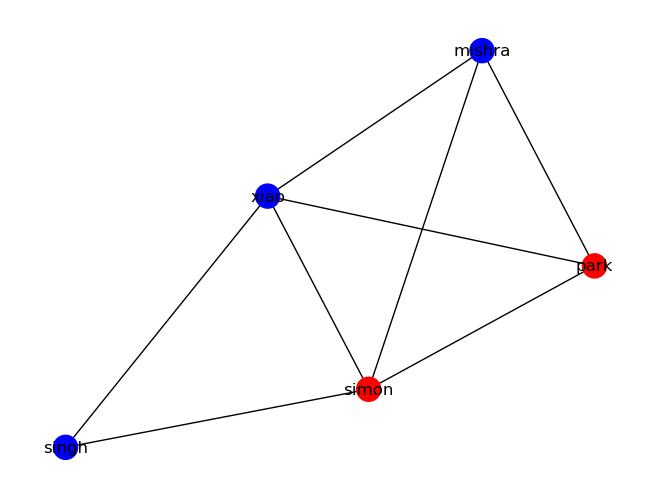

In [48]:
nx.draw(G_eiindex, with_labels=True, node_color=[G_eiindex.nodes[i]['color'] for i in G_eiindex.nodes])

In [49]:
def ego_EI_idx(graph_object):
    EI_dic = {}
    for k in graph_object.nodes:
        external = 0
        internal = 0
        try:
            for i in graph_object.edges(k):
                if graph_object.nodes[i[1]]['title'] == graph_object.nodes[k]['title']:
                    internal += 1
                else:
                    external += 1
        except ZeroDivisionError:
            pass
        if external + internal != 0:
            EI_dic[k] = (external - internal) / (external + internal)
        else:
            EI_dic[k] = 0
    nx.set_node_attributes(graph_object, EI_dic, name="ei_idx")

In [50]:
ego_EI_idx(G_eiindex)

In [51]:
G_eiindex.nodes['mishra']

{'title': 'Representative', 'color': 'blue', 'ei_idx': 0.3333333333333333}

>* In order to calculate the graph-level homophily, there is another method called `assortativity coefficient`.
>* The assortativity coefficient is a measure used to quantify the degree to which nodes in a network tend to be connected to other nodes that are similar or dissimilar.
> * 1: Perfect assortative
> * -1: Perfect disassortative

In [52]:
nx.attribute_assortativity_coefficient(G_eiindex, 'title')

-0.2698412698412698

>* If we want to measure the level of clustering in the network, we can use (1) transitivity and (2) clustering coefficient.
>* `Transitivity` is the ratio of triangles to triplets in the network.
>* `Clustering coefficient` is the clustering coefficient of the node.
>* `Average clustering` is the average clustering coefficient of all the nodes in the network (Graph-level clustering).

> * Why do we look at `triangles` in the network?
>* https://faculty.ucr.edu/~hanneman/nettext/C8_Embedding.html
>* https://bryangraham.github.io/econometrics/downloads/working_papers/DynamicNetworks/Homophily_and_Transitivity_April2016.pdf

<img src="../week8/transitivity.png" width=3500px height=80px />

<img src="../week8/transitivity-figure.png" width=800px height=300px />

<img src="../week8/transitivity-1.png" width=700px height=70px />

<img src="../week8/transitivity-2.png" width=700px height=120px />

<img src="../week8/transitivity-3.png" width=700px height=120px />

<img src="../week8/triadic_closure.png" width=300px height=700px />

In [53]:
nx.transitivity(G_eiindex) #transitivity 

0.7894736842105263

<img src="../week8/transitivity-metric.png" width=300px height=100px />

In [54]:
nx.clustering(G_eiindex) #clustering coefficient

{'mishra': 1.0,
 'park': 1.0,
 'singh': 1.0,
 'xiao': 0.6666666666666666,
 'simon': 0.6666666666666666}

<img src="../week8/clustering-metric.png" width=500px height=100px />

In [55]:
nx.average_clustering(G_eiindex) #average clustering coefficient

0.8666666666666666

>* Louvain community detection algorithm is a method to detect the communities in the network.
>* First, it iteratively optimizes the modularity score of the network by moving nodes between communities.
>* Modularity:a measure of the structure of networks or graphs which measures the strength of division of a network into modules (also called groups, clusters or communities).
>* Second, it stops when the modularity score cannot be increased further.
>* Third, it returns the communities as the output.

<img src="../week8/louvain_community.png" width=700px height=300px />

>* `pip install community`
>* `pip install python-louvain`

In [56]:
import community.community_louvain
len(nx.community.louvain_communities(G)) #community detection

155

#### Practice

In [57]:
data=pd.read_csv('../week5/subset-2021-01-11-voter_fraud.csv')

>* Let's see what it has for column names.

In [58]:
#YOUR CODE HERE

>* Let's subset the data to have only `bodywithurls`, `username`, `followers`, and `following` columns.

In [59]:
#YOUR CODE HERE

>* Q. Print the first 5 rows of the DataFrame.

In [60]:
#YOUR CODE HERE

>* Make the `username` column lowercase.

In [61]:
#YOUR CODE HERE

> * Looks like there are duplicates in the dataset. Let's remove the duplicates.

In [62]:
#YOUR CODE HERE

> * Let's extract the mentions from the `bodywithurls` column and create a new column `mentions` with the mentions.

In [63]:
#YOUR CODE HERE

> * Let's build edges between the users who have mentioned.
> * To do so, we will use the `mentions` column and iterate over the rows to create edges between the users in the `mention` column.

In [64]:
#YOUR CODE HERE

>* Create an empty graph object `P` 

In [65]:
#YOUR CODE HERE

>* Populate the graph `p` with the edges (where you put the tuples to represent the edges)
>* You may have to use the `add_edges_from` method to add the edges to the graph.

In [66]:
#YOUR CODE HERE

>* How many unique nodes are there in the graph `P`?
>* Use `.nodes()` method to get the unique nodes.

In [67]:
#YOUR CODE HERE

>* In the DataFrame, there is a column called `followers` and `following`.
>* Let's add the `followers` and `following` as the node attributes to the graph `P`.
>* Remember how to deal with the nodes that are not in `username` column. If the node is not in the `username` column, add 0 for `followers` and `following` attributes.

In [68]:
#YOUR CODE HERE

>* Calculate the degree centrality of the graph `P` and assign the value of the degree centrality to the node as the node attribute.
>* Use the `nx.degree_centrality` method to calculate the degree centrality.
>* The name of attribute should be `degree_centrality`.

In [69]:
#YOUR CODE HERE